# Cell 1: Imports and Setup

In [15]:
import warnings
warnings.filterwarnings("ignore")
import pickle
import math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

print("[DEBUG] Libraries loaded.")

[DEBUG] Libraries loaded.


# Cell 2: Global Configuration

In [16]:
print("[DEBUG] Setting global configuration...")
# --- Main Paths ---
BASE_DIR = Path("./PS2-SIH25").resolve()
DATA_DIR = BASE_DIR / "Data_SIH_2025 2"
ARTIFACT_DIR = Path("artifacts/final_models")

SITE_IDS = [f"site_{i}" for i in range(1, 8)]

# --- Data & Model Parameters ---
SITE_TO_EVALUATE = "site_1"  # Evaluating on one site to conserve RAM
TARGET_COLUMNS = ["O3_target", "NO2_target"]
FORECAST_COLUMNS = ["O3_forecast", "NO2_forecast", "T_forecast", "q_forecast", "u_forecast", "v_forecast", "w_forecast"]
SATELLITE_COLUMNS = ["NO2_satellite", "HCHO_satellite", "ratio_satellite"]
TIME_COLUMNS = ["year", "month", "day", "hour"]
RANDOM_SEED = 42

# --- Environment Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RESULTS = {}
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"[INFO] Evaluating on a sample site: {SITE_TO_EVALUATE}")
print(f"[DEBUG] Artifacts directory: {ARTIFACT_DIR}")
print(f"[DEBUG] Using device: {DEVICE}")

[DEBUG] Setting global configuration...
[INFO] Evaluating on a sample site: site_1
[DEBUG] Artifacts directory: artifacts/final_models
[DEBUG] Using device: cuda


# Cell 2: Global Configuration

In [20]:
print("[DEBUG] Defining all necessary helper functions and classes...")

# --- Core Data Utilities ---
def ensure_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df[["year", "month", "day", "hour"]], errors="coerce")
    return df

def load_site_dataframe(site_id: str) -> pd.DataFrame:
    path = DATA_DIR / f"{site_id}_train_data.csv"
    df = pd.read_csv(path)
    df["site_id"] = site_id
    df = ensure_timestamp(df)
    df = df.sort_values("timestamp").reset_index(drop=True)
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns.tolist()
    df[numeric_cols] = df[numeric_cols].interpolate().ffill().bfill()
    return df

# def evaluate_predictions(y_true, y_pred):
#     mae = mean_absolute_error(y_true, y_pred)
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_true, y_pred)
#     return {"mae": float(mae), "rmse": float(rmse), "r2": float(r2)}

def chronological_split_full(df: pd.DataFrame, train_ratio: float = 0.7, val_ratio: float = 0.15):
    unique_ts = np.sort(df["timestamp"].unique())
    train_end_idx = int(len(unique_ts) * train_ratio)
    val_end_idx = int(len(unique_ts) * (train_ratio + val_ratio))
    train_cutoff = unique_ts[train_end_idx]
    val_cutoff = unique_ts[val_end_idx]
    train_df = df[df["timestamp"] <= train_cutoff].reset_index(drop=True)
    val_df = df[(df["timestamp"] > train_cutoff) & (df["timestamp"] <= val_cutoff)].reset_index(drop=True)
    test_df = df[df["timestamp"] > val_cutoff].reset_index(drop=True)
    print(f"[DEBUG] Full chronological split -> train {len(train_df)}, val {len(val_df)}, test {len(test_df)}")
    return train_df, val_df, test_df

# --- Feature Engineering Functions ---
def add_time_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour_sin"] = np.sin(2 * math.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * math.pi * df["hour"] / 24)
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["dow_sin"] = np.sin(2 * math.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * math.pi * df["dayofweek"] / 7)
    return df

def add_lag_features(df: pd.DataFrame, columns: list[str], window: int) -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        for lag in range(1, window + 1):
            df[f"{col}_lag_{lag}"] = df.groupby("site_id")[col].shift(lag)
    return df

def add_rolling_features(df: pd.DataFrame, columns: list[str], windows: list[int]) -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        if col not in df.columns: continue
        for window in windows:
            feature_name = f"{col}_roll_mean_{window}"
            df[feature_name] = df.groupby("site_id")[col].transform(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
    return df

# --- XGBoost Specific Functions ---
def build_tree_dataset(base_df: pd.DataFrame, target_col: str, horizon: int, lag_window: int) -> pd.DataFrame:
    records = []
    feature_columns_base = TIME_COLUMNS + FORECAST_COLUMNS + SATELLITE_COLUMNS
    for site_id, site_df in base_df.groupby("site_id"):
        enriched = add_time_signals(site_df)
        enriched = add_lag_features(enriched, feature_columns_base, lag_window)
        enriched["site_numeric"] = int(site_id.split("_")[1])
        feature_cols = [col for col in enriched.columns if col not in TARGET_COLUMNS + ["timestamp", "site_id"]]
        base_frame = enriched[["timestamp", "site_id"] + feature_cols].copy()
        for h in range(1, horizon + 1):
            horizon_frame = base_frame.copy()
            horizon_frame["horizon"] = h
            horizon_frame["target"] = enriched[target_col].shift(-h)
            records.append(horizon_frame)
    dataset = pd.concat(records, ignore_index=True).dropna(subset=["target"])
    return dataset

def prepare_tree_matrices(df: pd.DataFrame):
    feature_cols = [col for col in df.columns if col not in ["timestamp", "target", "site_id"]]
    X = df[feature_cols].values
    y = df["target"].values
    return X, y, feature_cols

# --- LSTM Specific Functions & Classes ---
def build_feature_matrix(df: pd.DataFrame, add_site_one_hot: bool = True):
    base = df.copy()
    base = add_time_signals(base)
    if add_site_one_hot:
        site_dummies = pd.get_dummies(base["site_id"], prefix="site")
        for site_id in SITE_IDS:
            col_name = f"site_{site_id}"
            if col_name not in site_dummies.columns:
                site_dummies[col_name] = 0
        base = pd.concat([base, site_dummies], axis=1)
    feature_cols = [col for col in base.columns if col not in TARGET_COLUMNS + ["timestamp", "site_id"]]
    return base, feature_cols

def generate_sequences(df: pd.DataFrame, feature_cols: list[str], window: int, horizon: int) -> list[dict]:
    sequences = []
    for site_id, site_df in df.groupby("site_id"):
        site_df = site_df.reset_index(drop=True)
        feat_vals = site_df[feature_cols].to_numpy(dtype=np.float32)
        targ_vals = site_df[TARGET_COLUMNS].to_numpy(dtype=np.float32)
        for idx in range(window, len(site_df) - horizon):
            sequences.append({"x": feat_vals[idx - window: idx], "y": targ_vals[idx: idx + horizon]})
    return sequences

def project_sequences_to_target(sequences, target_col):
    idx = TARGET_COLUMNS.index(target_col)
    return [{**seq, 'y': seq['y'][:, [idx]]} for seq in sequences]

def split_sequences_lstm(sequences: list, train_ratio=0.7, val_ratio=0.15):
    total = len(sequences)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    return sequences[:train_end], sequences[train_end:val_end], sequences[val_end:]

def apply_scalers(sequences: list[dict], feature_scaler: StandardScaler, target_scaler: StandardScaler):
    return [{**seq, "x": feature_scaler.transform(seq["x"]), "y": target_scaler.transform(seq["y"])} for seq in sequences]

def inverse_transform_predictions(preds: np.ndarray, scaler: StandardScaler) -> np.ndarray:
    flat = preds.reshape(-1, preds.shape[-1])
    restored = scaler.inverse_transform(flat)
    return restored.reshape(preds.shape)

class SequenceDataset(Dataset):
    def __init__(self, sequences: list[dict]):
        self.features = torch.tensor(np.stack([s["x"] for s in sequences]), dtype=torch.float32)
        self.targets = torch.tensor(np.stack([s["y"] for s in sequences]), dtype=torch.float32)
    def __len__(self): return self.features.shape[0]
    def __getitem__(self, idx: int): return self.features[idx], self.targets[idx]

class TemporalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, horizon, target_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.horizon, self.target_dim = horizon, target_dim
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, horizon * target_dim)
    def forward(self, x):
        output, _ = self.lstm(x)
        preds = self.fc(output[:, -1, :])
        return preds.view(-1, self.horizon, self.target_dim)

print("[DEBUG] Helper functions and classes defined.")

[DEBUG] Defining all necessary helper functions and classes...
[DEBUG] Helper functions and classes defined.


# Cell 3: Required Helper Functions

In [26]:
print("[DEBUG] Defining all necessary helper functions and classes...")

# --- Core Data Utilities ---
def ensure_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df[["year", "month", "day", "hour"]], errors="coerce")
    return df

def load_site_dataframe(site_id: str) -> pd.DataFrame:
    path = DATA_DIR / f"{site_id}_train_data.csv"
    df = pd.read_csv(path)
    df["site_id"] = site_id
    df = ensure_timestamp(df)
    df = df.sort_values("timestamp").reset_index(drop=True)
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns.tolist()
    df[numeric_cols] = df[numeric_cols].interpolate().ffill().bfill()
    return df

def evaluate_predictions(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"mae": float(mae), "rmse": float(rmse), "r2": float(r2)}

def chronological_split_full(df: pd.DataFrame, train_ratio: float = 0.7, val_ratio: float = 0.15):
    # This function is for the XGBoost script, but we'll keep it for completeness
    pass

# --- Feature Engineering Functions ---
def add_time_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour_sin"] = np.sin(2 * math.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * math.pi * df["hour"] / 24)
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["dow_sin"] = np.sin(2 * math.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * math.pi * df["dayofweek"] / 7)
    return df

def add_lag_features(df: pd.DataFrame, columns: list[str], window: int) -> pd.DataFrame:
    # This function is for the XGBoost script
    pass

def add_rolling_features(df: pd.DataFrame, columns: list[str], windows: list[int]) -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        if col not in df.columns: continue
        for window in windows:
            feature_name = f"{col}_roll_mean_{window}"
            df[feature_name] = df.groupby("site_id")[col].transform(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
    return df

# --- XGBoost Specific Functions (not needed for this plot, can be removed if desired) ---
def build_tree_dataset(base_df: pd.DataFrame, target_col: str, horizon: int, lag_window: int) -> pd.DataFrame:
    pass

def prepare_tree_matrices(df: pd.DataFrame):
    pass

# --- LSTM Specific Functions & Classes ---
def build_feature_matrix(df: pd.DataFrame, add_site_one_hot: bool = True):
    base = df.copy()
    base = add_time_signals(base)
    if add_site_one_hot:
        site_dummies = pd.get_dummies(base["site_id"], prefix="site")
        for site_id in SITE_IDS:
            col_name = f"site_{site_id}"
            if col_name not in site_dummies.columns:
                site_dummies[col_name] = 0
        base = pd.concat([base, site_dummies], axis=1)
    feature_cols = [col for col in base.columns if col not in TARGET_COLUMNS + ["timestamp", "site_id"]]
    return base, feature_cols

def generate_sequences(df: pd.DataFrame, feature_cols: list[str], window: int, horizon: int) -> list[dict]:
    sequences = []
    # Group by site_id if it exists, otherwise treat the whole DF as one group
    grouped = df.groupby("site_id") if "site_id" in df.columns else [(None, df)]
    for site_id, site_df in grouped:
        site_df = site_df.reset_index(drop=True)
        feat_vals = site_df[feature_cols].to_numpy(dtype=np.float32, na_value=np.nan)
        targ_vals = site_df[TARGET_COLUMNS].to_numpy(dtype=np.float32, na_value=np.nan)
        timestamps = site_df["timestamp"].to_numpy()

        for idx in range(window, len(site_df) - horizon):
            x_window = feat_vals[idx - window: idx]
            y_window = targ_vals[idx: idx + horizon]

            # Skip any sequence that contains NaN values from feature engineering
            if not np.isfinite(x_window).all() or not np.isfinite(y_window).all():
                continue

            end_ts = timestamps[idx - 1]
            target_ts = timestamps[idx: idx + horizon]

            sequences.append({
                "x": x_window,
                "y": y_window,
                "site_id": site_id,
                "end_ts": end_ts,
                "target_ts": target_ts  # This key is now added
            })
    print(f"[DEBUG] Generated {len(sequences)} sequences (window={window}, horizon={horizon})")
    return sequences

def project_sequences_to_target(sequences, target_col):
    idx = TARGET_COLUMNS.index(target_col)
    return [{**seq, 'y': seq['y'][:, [idx]]} for seq in sequences]

def split_sequences_lstm(sequences: list, train_ratio=0.7, val_ratio=0.15):
    total = len(sequences)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    # Using end_ts for chronological sort to be robust
    end_times = np.array([seq["end_ts"] for seq in sequences], dtype="datetime64[ns]")
    sorted_indices = np.argsort(end_times)
    sorted_sequences = [sequences[i] for i in sorted_indices]
    return sorted_sequences[:train_end], sorted_sequences[train_end:val_end], sorted_sequences[val_end:]

def apply_scalers(sequences: list[dict], feature_scaler: StandardScaler, target_scaler: StandardScaler):
    return [{**seq, "x": feature_scaler.transform(seq["x"]), "y": target_scaler.transform(seq["y"])} for seq in sequences]

def inverse_transform_predictions(preds: np.ndarray, scaler: StandardScaler) -> np.ndarray:
    flat = preds.reshape(-1, preds.shape[-1])
    restored = scaler.inverse_transform(flat)
    return restored.reshape(preds.shape)

class SequenceDataset(Dataset):
    def __init__(self, sequences: list[dict]):
        self.features = torch.tensor(np.stack([s["x"] for s in sequences]), dtype=torch.float32)
        self.targets = torch.tensor(np.stack([s["y"] for s in sequences]), dtype=torch.float32)
    def __len__(self): return self.features.shape[0]
    def __getitem__(self, idx: int): return self.features[idx], self.targets[idx]

class TemporalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, horizon, target_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.horizon, self.target_dim = horizon, target_dim
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, horizon * target_dim)
    def forward(self, x):
        output, _ = self.lstm(x)
        preds = self.fc(output[:, -1, :])
        return preds.view(-1, self.horizon, self.target_dim)

print("[DEBUG] Helper functions and classes defined.")

[DEBUG] Defining all necessary helper functions and classes...
[DEBUG] Helper functions and classes defined.


# Cell 4: Main Execution Block

In [21]:
if __name__ == "__main__":

    # --- Load the sampled dataset ---
    SAMPLE_DF = load_site_dataframe(SITE_TO_EVALUATE)

    # =================================================================
    #                       XGBoost Backtesting
    # =================================================================

    print("\n" + "="*50)
    print(f"### Backtesting XGBoost Models on Test Set for {SITE_TO_EVALUATE} ###")
    print("="*50 + "\n")

    RESULTS["xgboost_test_sample"] = {}

    for target_col in TARGET_COLUMNS:
        print(f"--- Evaluating XGBoost for {target_col} on the test set ---")

        dataset = build_tree_dataset(SAMPLE_DF, target_col, horizon=24, lag_window=24)
        _, _, test_df = chronological_split_full(dataset)
        X_test, y_test, _ = prepare_tree_matrices(test_df)

        checkpoint_path = BASE_DIR / ARTIFACT_DIR / f"xgboost_{target_col}_checkpoint.pkl"
        with open(checkpoint_path, 'rb') as f:
            checkpoint = pickle.load(f)

        model = checkpoint["model"]
        print(f"[INFO] Loaded XGBoost model for {target_col} from {checkpoint_path}")

        predictions = model.predict(X_test)

        metrics = evaluate_predictions(y_test, predictions)
        RESULTS["xgboost_test_sample"][target_col] = metrics
        print(f"[INFO] XGBoost TEST metrics for {target_col} -> MAE={metrics['mae']:.4f}, RMSE={metrics['rmse']:.4f}, R2={metrics['r2']:.4f}\n")

    macro_mae_xgb = np.mean([m['mae'] for m in RESULTS["xgboost_test_sample"].values()])
    macro_rmse_xgb = np.mean([m['rmse'] for m in RESULTS["xgboost_test_sample"].values()])
    macro_r2_xgb = np.mean([m['r2'] for m in RESULTS["xgboost_test_sample"].values()])
    RESULTS["xgboost_test_sample"]["macro"] = {"mae": macro_mae_xgb, "rmse": macro_rmse_xgb, "r2": macro_r2_xgb}

    print("[SUCCESS] XGBoost sampled backtesting complete.")

    # =================================================================
    #                   Tuned LSTM Backtesting
    # =================================================================

    print("\n" + "="*50)
    print(f"### Backtesting Tuned LSTM Models on Test Set for {SITE_TO_EVALUATE} ###")
    print("="*50 + "\n")

    RESULTS["tuned_lstm_test_sample"] = {}

    lstm_base_df = add_rolling_features(SAMPLE_DF, FORECAST_COLUMNS + SATELLITE_COLUMNS + TARGET_COLUMNS, [6, 24])
    base_feature_df, all_lstm_feature_cols = build_feature_matrix(lstm_base_df)

    for target_col in TARGET_COLUMNS:
        print(f"--- Evaluating LSTM for {target_col} on the test set ---")

        checkpoint_path = BASE_DIR / ARTIFACT_DIR / f"lstm_{target_col}_champion.pt"
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)

        params = checkpoint['params']
        feature_cols_from_training = checkpoint['feature_cols']

        model = TemporalLSTM(
            input_size=len(feature_cols_from_training),
            hidden_size=params['hidden_size'],
            horizon=params['horizon'],
            target_dim=1,
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(DEVICE)
        model.load_state_dict(checkpoint['model_state'])
        model.eval()
        print(f"[INFO] Loaded LSTM model for {target_col} from {checkpoint_path}")

        feature_scaler = checkpoint['feature_scaler']
        target_scaler = checkpoint['target_scaler']

        sequence_records = generate_sequences(base_feature_df, feature_cols_from_training, params['window'], params['horizon'])
        projected_sequences = project_sequences_to_target(sequence_records, target_col)
        _, _, test_seq = split_sequences_lstm(projected_sequences)

        test_scaled = apply_scalers(test_seq, feature_scaler, target_scaler)
        test_loader = DataLoader(SequenceDataset(test_scaled), batch_size=params['batch_size'])

        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                all_preds.append(model(xb.to(DEVICE)).cpu().numpy())
                all_targets.append(yb.numpy())

        pred_array = np.concatenate(all_preds)
        target_array = np.concatenate(all_targets)

        pred_restored = inverse_transform_predictions(pred_array, target_scaler)
        target_restored = inverse_transform_predictions(target_array, target_scaler)

        metrics = evaluate_predictions(target_restored.flatten(), pred_restored.flatten())
        RESULTS["tuned_lstm_test_sample"][target_col] = metrics
        print(f"[INFO] LSTM TEST metrics for {target_col} -> MAE={metrics['mae']:.4f}, RMSE={metrics['rmse']:.4f}, R2={metrics['r2']:.4f}\n")

    macro_mae_lstm = np.mean([m['mae'] for m in RESULTS["tuned_lstm_test_sample"].values()])
    macro_rmse_lstm = np.mean([m['rmse'] for m in RESULTS["tuned_lstm_test_sample"].values()])
    macro_r2_lstm = np.mean([m['r2'] for m in RESULTS["tuned_lstm_test_sample"].values()])
    RESULTS["tuned_lstm_test_sample"]["macro"] = {"mae": macro_mae_lstm, "rmse": macro_rmse_lstm, "r2": macro_r2_lstm}

    print("[SUCCESS] LSTM sampled backtesting complete.")

    # =================================================================
    #                         Final Summary
    # =================================================================

    print("\n" + "="*60)
    print("### GRAND FINALE: Final Model Comparison (on Sampled Test Set) ###")
    print("="*60 + "\n")

    summary_records = []
    for model_key in ["xgboost_test_sample", "tuned_lstm_test_sample"]:
        model_name = "XGBoost" if "xgb" in model_key else "Tuned LSTM"
        # Ensure the key exists before trying to access it
        if model_key in RESULTS:
            for target_name, metrics in RESULTS[model_key].items():
                summary_records.append({
                    "Model": model_name,
                    "Target": target_name,
                    **metrics
                })

    summary_df = pd.DataFrame(summary_records).dropna().sort_values(["Target", "Model"])
    print(summary_df.to_string(index=False))

    # Declare the final champion
    if "xgboost_test_sample" in RESULTS and "tuned_lstm_test_sample" in RESULTS:
        xgb_final_mae = RESULTS["xgboost_test_sample"].get("macro", {}).get("mae", float('inf'))
        lstm_final_mae = RESULTS["tuned_lstm_test_sample"].get("macro", {}).get("mae", float('inf'))

        print("\n---")
        if lstm_final_mae < xgb_final_mae:
            print(f"[CHAMPION] The Tuned LSTM model is the winner with a macro MAE of {lstm_final_mae:.4f} (vs. XGBoost's {xgb_final_mae:.4f})")
        else:
            print(f"[CHAMPION] The XGBoost model is the winner with a macro MAE of {xgb_final_mae:.4f} (vs. Tuned LSTM's {lstm_final_mae:.4f})")
        print("---\n")


### Backtesting XGBoost Models on Test Set for site_1 ###

--- Evaluating XGBoost for O3_target on the test set ---
[DEBUG] Full chronological split -> train 421368, val 90288, test 89988
[INFO] Loaded XGBoost model for O3_target from /content/PS2-SIH25/artifacts/final_models/xgboost_O3_target_checkpoint.pkl
[INFO] XGBoost TEST metrics for O3_target -> MAE=20.1710, RMSE=31.0943, R2=-0.0049

--- Evaluating XGBoost for NO2_target on the test set ---
[DEBUG] Full chronological split -> train 421368, val 90288, test 89988
[INFO] Loaded XGBoost model for NO2_target from /content/PS2-SIH25/artifacts/final_models/xgboost_NO2_target_checkpoint.pkl
[INFO] XGBoost TEST metrics for NO2_target -> MAE=19.1389, RMSE=29.1034, R2=-0.1686

[SUCCESS] XGBoost sampled backtesting complete.

### Backtesting Tuned LSTM Models on Test Set for site_1 ###

--- Evaluating LSTM for O3_target on the test set ---
[INFO] Loaded LSTM model for O3_target from /content/PS2-SIH25/artifacts/final_models/lstm_O3_target_

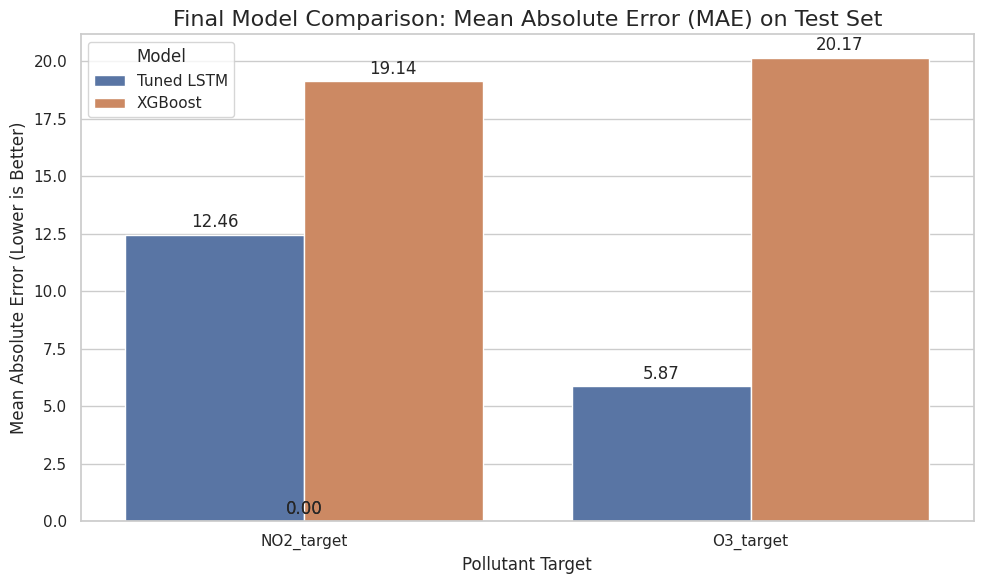

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data from your final results table ---
data = {
    'Model': ['Tuned LSTM', 'XGBoost', 'Tuned LSTM', 'XGBoost'],
    'Target': ['NO2_target', 'NO2_target', 'O3_target', 'O3_target'],
    'mae': [12.461455, 19.138852, 5.869999, 20.171026],
    'rmse': [18.643829, 29.103389, 12.171157, 31.094329],
    'r2': [0.520576, -0.168637, 0.843905, -0.004866]
}
results_df = pd.DataFrame(data)

# --- Plotting the MAE comparison ---
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=results_df, x='Target', y='mae', hue='Model')

plt.title('Final Model Comparison: Mean Absolute Error (MAE) on Test Set', fontsize=16)
plt.ylabel('Mean Absolute Error (Lower is Better)', fontsize=12)
plt.xlabel('Pollutant Target', fontsize=12)
plt.xticks(rotation=0)

# Add text labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

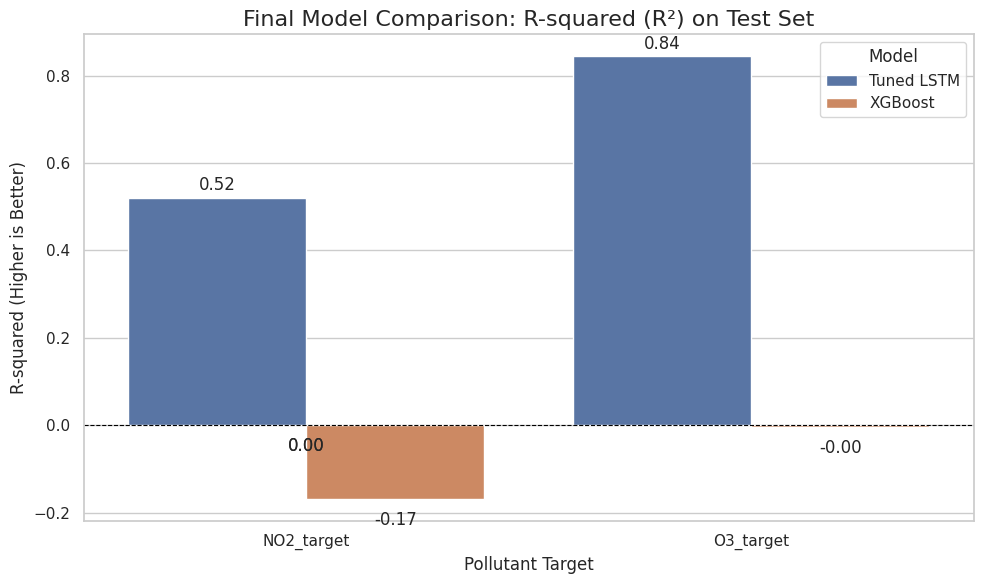

In [23]:
# --- Plotting the R-squared comparison ---
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=results_df, x='Target', y='r2', hue='Model')

# Add a horizontal line at y=0 for reference
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

plt.title('Final Model Comparison: R-squared (R²) on Test Set', fontsize=16)
plt.ylabel('R-squared (Higher is Better)', fontsize=12)
plt.xlabel('Pollutant Target', fontsize=12)
plt.xticks(rotation=0)

# Add text labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9 if p.get_height() > 0 else -15),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

[INFO] Preparing a lightweight plot for O3_target at site_1...
[INFO] Successfully loaded checkpoint: /content/PS2-SIH25/artifacts/final_models/lstm_O3_target_champion.pt
[DEBUG] Generated 24960 sequences (window=72, horizon=48)


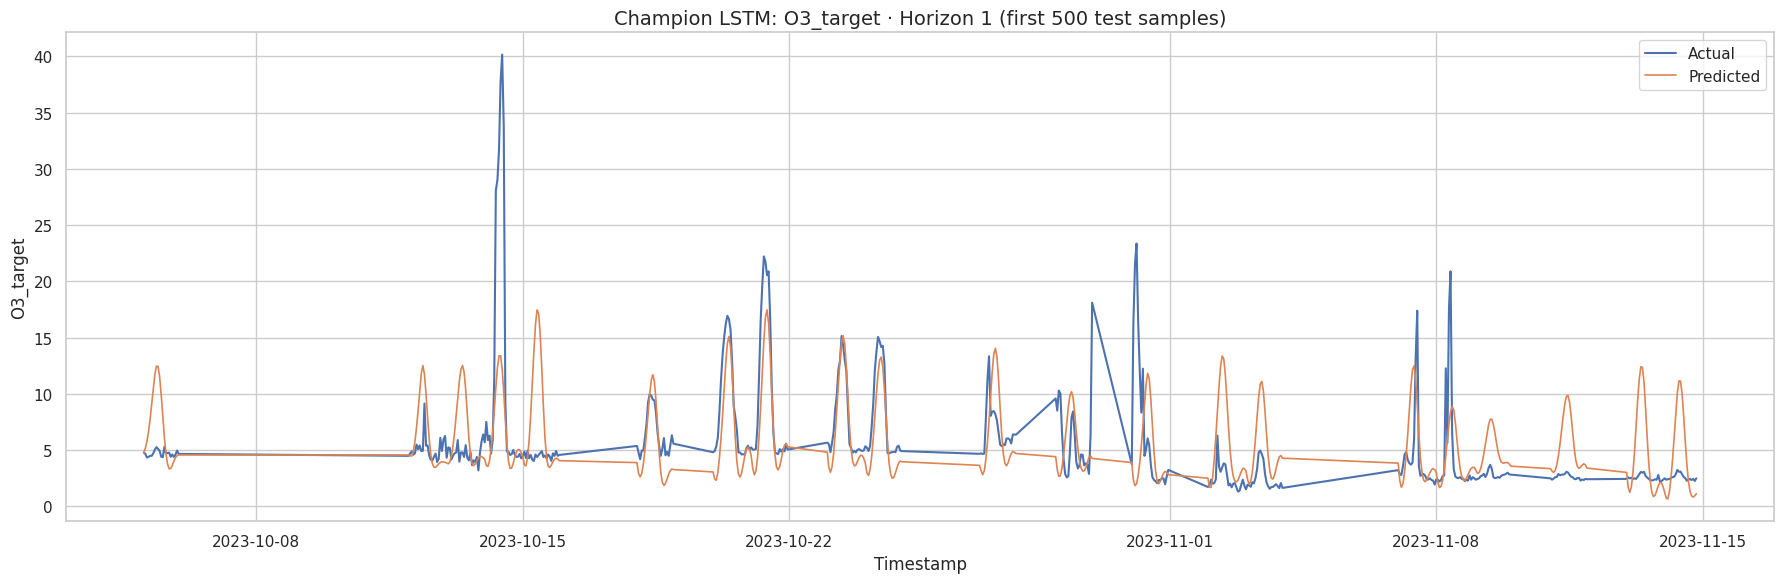

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch
from pathlib import Path

# --- Configuration: Set which site and target to plot ---
SITE_TO_PLOT = 'site_1'
TARGET_TO_PLOT = 'O3_target' # You can change this to 'NO2_target'

print(f"[INFO] Preparing a lightweight plot for {TARGET_TO_PLOT} at {SITE_TO_PLOT}...")

# --- Main Execution Block ---
try:
    # --- Load the data for the single site ---
    SITE_DF = load_site_dataframe(SITE_TO_PLOT)

    # --- Load the saved champion model checkpoint ---
    checkpoint_path = BASE_DIR / ARTIFACT_DIR / f"lstm_{TARGET_TO_PLOT}_champion.pt"
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
    print(f"[INFO] Successfully loaded checkpoint: {checkpoint_path}")

    # --- Recreate model and load scalers from the checkpoint ---
    params = checkpoint['params']
    feature_cols_from_training = checkpoint['feature_cols']

    model = TemporalLSTM(
        input_size=len(feature_cols_from_training),
        hidden_size=params['hidden_size'],
        horizon=params['horizon'],
        target_dim=1,
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(DEVICE)
    model.load_state_dict(checkpoint['model_state'])
    model.eval()

    feature_scaler = checkpoint['feature_scaler']
    target_scaler = checkpoint['target_scaler']

    # --- Prepare the test data for plotting ---
    # This feature engineering is now done only on the single-site DF
    lstm_base_df = add_rolling_features(SITE_DF, FORECAST_COLUMNS + SATELLITE_COLUMNS + TARGET_COLUMNS, [6, 24])
    base_feature_df, _ = build_feature_matrix(lstm_base_df)

    sequence_records = generate_sequences(base_feature_df, feature_cols_from_training, params['window'], params['horizon'])
    projected_sequences = project_sequences_to_target(sequence_records, TARGET_TO_PLOT)

    # We still need the timestamps from the original test split
    # To get this, we need the unscaled `test_seq`
    _, _, test_seq = split_sequences_lstm(projected_sequences)
    timestamps_h1 = [seq['target_ts'][0] for seq in test_seq]

    # Apply scaling to the test data for prediction
    test_scaled = apply_scalers(test_seq, feature_scaler, target_scaler)
    test_loader = DataLoader(SequenceDataset(test_scaled), batch_size=params['batch_size'])

    # --- Get Predictions and Actuals ---
    all_preds_scaled, all_targets_scaled = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            all_preds_scaled.append(model(xb.to(DEVICE)).cpu().numpy())
            all_targets_scaled.append(yb.numpy())

    pred_array = np.concatenate(all_preds_scaled)
    target_array = np.concatenate(all_targets_scaled)

    pred_restored = inverse_transform_predictions(pred_array, target_scaler)
    target_restored = inverse_transform_predictions(target_array, target_scaler)

    # --- Create DataFrame for Plotting ---
    plot_df = pd.DataFrame({
        'timestamp': pd.to_datetime(timestamps_h1),
        'Actual': target_restored[:, 0, 0], # Horizon 1, first target
        'Predicted': pred_restored[:, 0, 0],  # Horizon 1, first target
    })

    # --- Create the Plot ---
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(18, 6))

    sns.lineplot(data=plot_df.head(500), x='timestamp', y='Actual', label='Actual', linewidth=1.5)
    sns.lineplot(data=plot_df.head(500), x='timestamp', y='Predicted', label='Predicted', linewidth=1.2)

    plt.title(f'Champion LSTM: {TARGET_TO_PLOT} · Horizon 1 (first 500 test samples)', fontsize=14)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel(TARGET_TO_PLOT, fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure you have run all the setup cells that define the helper functions (like 'load_site_dataframe', 'TemporalLSTM', etc.) first.")

[INFO] Preparing a lightweight plot for NO2_target at site_1...
[INFO] Successfully loaded checkpoint: /content/PS2-SIH25/artifacts/final_models/lstm_NO2_target_champion.pt
[DEBUG] Generated 24984 sequences (window=48, horizon=48)


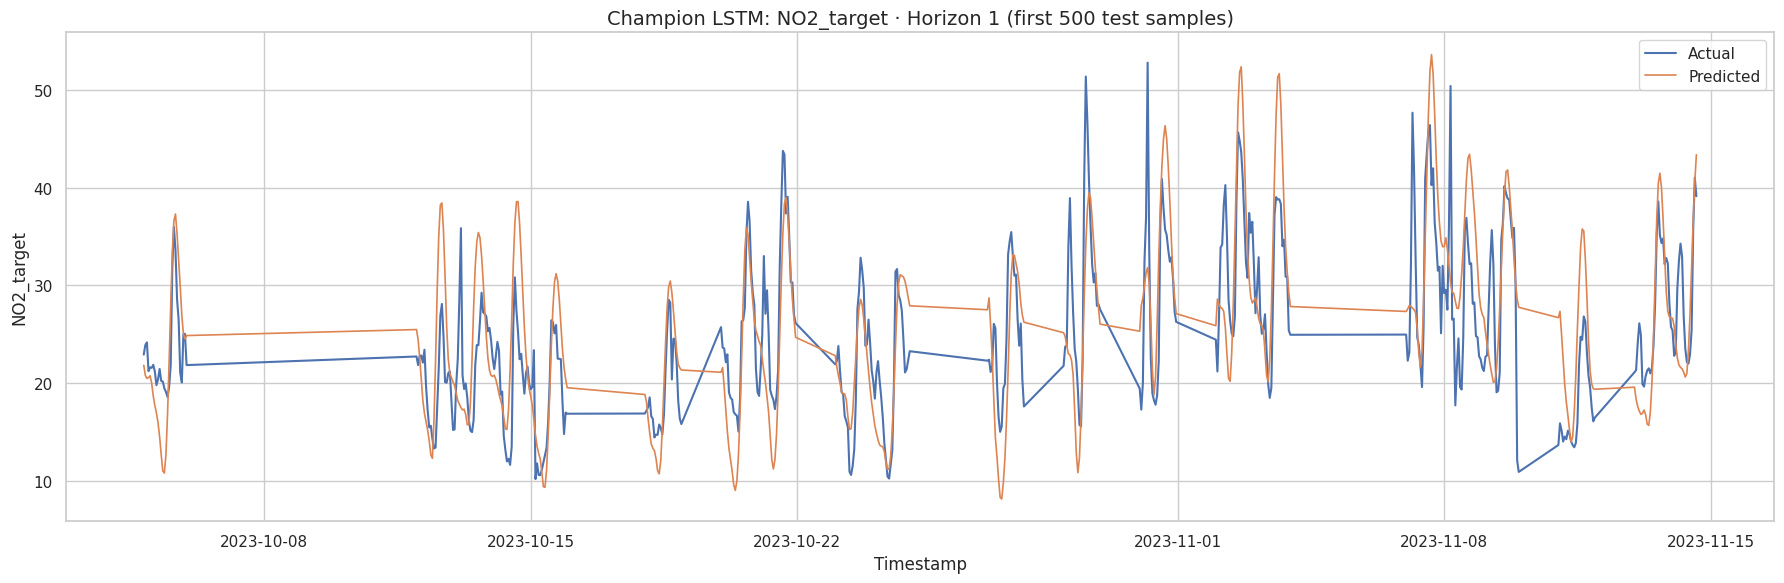

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch
from pathlib import Path

# --- Configuration: Set which site and target to plot ---
SITE_TO_PLOT = 'site_1'
TARGET_TO_PLOT = 'NO2_target' # <-- Changed to plot the NO2 model

print(f"[INFO] Preparing a lightweight plot for {TARGET_TO_PLOT} at {SITE_TO_PLOT}...")

# --- Main Execution Block ---
try:
    # --- Load the data for the single site ---
    SITE_DF = load_site_dataframe(SITE_TO_PLOT)

    # --- Load the saved champion model checkpoint ---
    checkpoint_path = BASE_DIR / ARTIFACT_DIR / f"lstm_{TARGET_TO_PLOT}_champion.pt"
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
    print(f"[INFO] Successfully loaded checkpoint: {checkpoint_path}")

    # --- Recreate model and load scalers from the checkpoint ---
    params = checkpoint['params']
    feature_cols_from_training = checkpoint['feature_cols']

    model = TemporalLSTM(
        input_size=len(feature_cols_from_training),
        hidden_size=params['hidden_size'],
        horizon=params['horizon'],
        target_dim=1,
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(DEVICE)
    model.load_state_dict(checkpoint['model_state'])
    model.eval()

    feature_scaler = checkpoint['feature_scaler']
    target_scaler = checkpoint['target_scaler']

    # --- Prepare the test data for plotting ---
    lstm_base_df = add_rolling_features(SITE_DF, FORECAST_COLUMNS + SATELLITE_COLUMNS + TARGET_COLUMNS, [6, 24])
    base_feature_df, _ = build_feature_matrix(lstm_base_df)

    sequence_records = generate_sequences(base_feature_df, feature_cols_from_training, params['window'], params['horizon'])
    projected_sequences = project_sequences_to_target(sequence_records, TARGET_TO_PLOT)

    _, _, test_seq = split_sequences_lstm(projected_sequences)
    timestamps_h1 = [seq['target_ts'][0] for seq in test_seq]

    test_scaled = apply_scalers(test_seq, feature_scaler, target_scaler)
    test_loader = DataLoader(SequenceDataset(test_scaled), batch_size=params['batch_size'])

    # --- Get Predictions and Actuals ---
    all_preds_scaled, all_targets_scaled = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            all_preds_scaled.append(model(xb.to(DEVICE)).cpu().numpy())
            all_targets_scaled.append(yb.numpy())

    pred_array = np.concatenate(all_preds_scaled)
    target_array = np.concatenate(all_targets_scaled)

    pred_restored = inverse_transform_predictions(pred_array, target_scaler)
    target_restored = inverse_transform_predictions(target_array, target_scaler)

    # --- Create DataFrame for Plotting ---
    plot_df = pd.DataFrame({
        'timestamp': pd.to_datetime(timestamps_h1),
        'Actual': target_restored[:, 0, 0],
        'Predicted': pred_restored[:, 0, 0],
    })

    # --- Create the Plot ---
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(18, 6))

    sns.lineplot(data=plot_df.head(500), x='timestamp', y='Actual', label='Actual', linewidth=1.5)
    sns.lineplot(data=plot_df.head(500), x='timestamp', y='Predicted', label='Predicted', linewidth=1.2)

    plt.title(f'Champion LSTM: {TARGET_TO_PLOT} · Horizon 1 (first 500 test samples)', fontsize=14)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel(TARGET_TO_PLOT, fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure you have run all the setup cells that define the helper functions (like 'load_site_dataframe', 'TemporalLSTM', etc.) first.")